# CS 5664 Semester Project Notebook
## Paper Title: From Bach to Snoop Dogg: Mapping Musical Influence on Spotify
- Authors: Mark Shelton & Charles Wiecking
- Emails: sheltonml@vt.edu & wieckingcp23@vt.edu
- PIDs: sheltonml & wieckingcp23



### Importing Packages
All package imports are in this cell for future cell clarity

In [73]:
import ast 
import community as community_louvain
import kagglehub
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import seaborn as sns
from collections import Counter
from networkx.algorithms.link_prediction import adamic_adar_index
from networkx.algorithms.link_prediction import jaccard_coefficient
from networkx.algorithms.link_prediction import preferential_attachment

### Getting the Dataset
- Requires Kaggle API Key (Instructions: https://www.kaggle.com/docs/api)
- Dataset Link: https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network
- Shows location files were downloaded to
### **Comment out when ran**

In [74]:
"""
# Download the dataset
path = kagglehub.dataset_download("jfreyberg/spotify-artist-feature-collaboration-network")
print("Dataset Path:", path)
"""

'\n# Download the dataset\npath = kagglehub.dataset_download("jfreyberg/spotify-artist-feature-collaboration-network")\nprint("Dataset Path:", path)\n'

## 1. Load the Spotify Collaboration Dataset

**Purpose**  
- Load the primary data files containing artist and collaboration information.  
- `nodes.csv` contains artist metadata such as name, popularity, followers, and genres.  
- `edges.csv` represents collaboration edges between artists by their Spotify IDs.

**This includes:**  
- **1.1 Preview of Node Data**: First five rows of the artist metadata table.  
- **1.2 Preview of Edge Data**: Sample edges showing undirected artist collaborations.

In [75]:
# Load node and edge data
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

# Basic shape information
num_nodes = nodes_df.shape[0]
num_edges = edges_df.shape[0]

# Basic Graph Stats
print(f"Loaded {num_nodes:,} artists and {num_edges:,} collaborations.")

Loaded 156,422 artists and 300,386 collaborations.


### 1.1 Preview of Node Data

Below are the first five rows of the artist metadata table.


In [76]:
# Display first 5 rows of nodes
nodes_df.head()

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']


### 1.2 Preview of Edge Data

Each row represents a collaboration between two artists (undirected edge).

In [77]:
# Display first 5 rows of edges
edges_df.head()

,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0


## Section 1 Summary: Loading the Dataset

We successfully imported metadata for 156,422 artists and 300,386 collaboration edges.  
- Artist metadata includes fields like `name`, `followers`, `popularity`, `genres`, and `chart_hits`.
- Each edge connects two artists based on real-world Spotify collaborations.

This completes the dataset setup and prepares us to construct the graph representation of the collaboration network in Section 2.

## 2. Basic Dataset Analysis

**Purpose**  
- Conduct exploratory analysis to understand the structure and content of the dataset.  
- Examine numerical and text-based fields before constructing the graph.

**This includes:**  
- **2.1 Missing Value Check**: Assess nulls in metadata and collaboration edges.  
- **2.2 Sample Genre and Chart Hit Distributions**: Preview formatting and diversity of genre and chart metadata.

In [78]:
# Basic stats for numeric fields in the nodes (artists) dataset
nodes_df[["followers", "popularity"]].describe()

,followers,popularity
count,1.564180e+05,156422.000000
mean,8.622371e+04,21.157497
std,9.401001e+05,18.338290
min,0.000000e+00,0.000000
25%,2.400000e+01,4.000000
50%,3.630000e+02,18.000000
75%,6.258000e+03,34.000000
max,1.021569e+08,100.000000


### 2.1 Missing Value Check

We now check for missing or null values across the key fields in both datasets.


In [79]:
print("Missing values in artist (nodes) dataset:")
display(nodes_df.isnull().sum())

print("\nMissing values in collaboration (edges) dataset:")
display(edges_df.isnull().sum())


Missing values in artist (nodes) dataset:


spotify_id         0
name               4
followers          4
popularity         0
genres             0
chart_hits    136781
dtype: int64


Missing values in collaboration (edges) dataset:


id_0    0
id_1    0
dtype: int64

### 2.2 Sample Genre and Chart Hit Distributions

To get a feel for the text-based fields, we’ll preview:
- A few unique genre lists
- A few examples of chart history entries

In [80]:
# Unique genre samples (first 10 non-empty genre entries)
genre_samples = nodes_df[nodes_df["genres"].str.len() > 2]["genres"].dropna().unique()[:10]
print("Sample Genre Entries:")
for entry in genre_samples:
    print("-", entry)

# Unique chart hit samples
chart_samples = nodes_df[nodes_df["chart_hits"].str.len() > 2]["chart_hits"].dropna().unique()[:10]
print("\nSample Chart Hit Entries:")
for entry in chart_samples:
    print("-", entry)


Sample Genre Entries:
- ['nordic house', 'russelater']
- ['christlicher rap', 'german hip hop']
- ['dancehall', 'lovers rock', 'modern reggae', 'reggae fusion']
- ['classic swedish pop', 'norrbotten indie', 'swedish pop']
- ['swedish drill', 'swedish hip hop', 'swedish trap', 'swedish trap pop']
- ['francoton']
- ['ukrainian hip hop', 'ukrainian pop', 'ukrainian rock']
- ['norwegian pop rap']
- ['suomi rock']
- ['orchestral soundtrack', 'soundtrack']

Sample Chart Hit Entries:
- ['no (3)']
- ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', 'vn (1)']
- ['de (1)']
- ['at (1)', 'de (1)']
- ['se (6)']
- ['it (2)']
- ['se (4)']
- ['fr (1)']
- ['ua (1)']
- ['do (1)']


## Section 2 Summary: Basic Dataset Analysis

- The dataset contains 156,422 artists, with highly skewed `followers` ranging from 0 to over 100 million.  
  - Median follower count is just 363, while the mean is ~86,200.
  - Popularity scores range from 0 to 100, with a median of 18.
- There are minimal missing values in key fields:
  - Only 4 missing entries in `name` and `followers`.
  - `chart_hits` is frequently missing (over 136,000 artists), but this field is optional for core analysis.
- Genres and chart hit information are available as list-like strings and appear cleanly structured.
  - Example genres include international and niche subgenres like "christlicher rap" or "swedish trap".
  - Chart entries include codes like "de (1)" or "no (3)", representing country and chart rank.

This confirms that the dataset is rich, non-uniform, and suitable for the next phase of analysis: network construction and enrichment.

## 3. Constructing the Collaboration Graph

**Purpose**  
- Build an undirected graph representing artist collaborations.  
- Enrich artist nodes with attributes for deeper network analysis.

**This includes:**  
- **3.1 Add Metadata to Nodes**: Attach name, popularity, followers, genre list, and chart history to each artist node.

In [81]:
# Create a graph from the edge list
G = nx.from_pandas_edgelist(
    edges_df,
    source="id_0",
    target="id_1",
    create_using=nx.Graph()
)

### 3.1 Add Metadata to Nodes

Each artist node in the graph is enriched with additional attributes from the metadata table (`nodes_df`).  
These include:
- `name`
- `followers`
- `popularity`
- `genres` (parsed from string to list)
- `chart_hits` (parsed from string to list)

In [82]:
# Add attributes to nodes from the artist metadata
for i, row in nodes_df.iterrows():
    artist_id = row["spotify_id"]
    if artist_id in G:
        G.nodes[artist_id].update({
            "name": row["name"],
            "followers": row["followers"],
            "popularity": row["popularity"],
            "genres": ast.literal_eval(row["genres"]) if pd.notna(row["genres"]) else [],
            "chart_hits": ast.literal_eval(row["chart_hits"]) if pd.notna(row["chart_hits"]) else []
        })

In [83]:
# Sample a node to confirm attributes
sample_node = next(iter(G.nodes))
print("\nSample node ID:", sample_node)
print("Attributes:", G.nodes[sample_node])



Sample node ID: 76M2Ekj8bG8W7X2nbx2CpF
Attributes: {'name': 'NGHTMRE', 'followers': 432754.0, 'popularity': 63, 'genres': ['bass trap', 'brostep', 'edm', 'electro house', 'electronic trap', 'pop dance'], 'chart_hits': []}


## Section 3 Summary: Collaboration Graph Construction

We successfully built an undirected graph from the Spotify artist collaboration dataset.

- Nodes represent artists, and edges represent real-world collaborations.
- We attached key metadata to each node, including artist name, popularity, follower count, genre, and chart history.
- This graph structure will now allow us to perform structural analysis and identify influential artists in the next section.

## 4. Network Structure and Centrality Analysis

**Purpose**  
- Analyze the structural properties of the collaboration graph using core network science concepts.
- Compute centrality and clustering metrics to identify influential artists and evaluate graph density.
- Assess whether structural influence correlates with commercial popularity.

This includes:
- **4.1 Centrality Measures**: Compute degree, eigenvector, and sampled betweenness centrality.  
- **4.2 Top 5 Artists by Each Centrality Metric**: Identify the most central artists across all metrics.  
- **4.3 Average Clustering Coefficient**: Evaluate local graph density via triangle formation.  
- **4.4 Correlation Between Centrality and Popularity**: Use Pearson correlation to assess alignment between network position and mainstream success.

In [84]:
# Basic structural properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

# Compute average degree
degrees = [deg for i, deg in G.degree()]
average_degree = sum(degrees) / len(degrees)

# Print network-level properties
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Is the graph directed? {'Yes' if is_directed else 'No'}")
print(f"Average degree: {average_degree:.4f}")


Number of nodes: 153327
Number of edges: 300386
Is the graph directed? No
Average degree: 3.9182


### 4.1 Centrality Measures

To identify influential artists in the collaboration network, we compute the following centrality metrics:

- **Degree Centrality**: Measures how many direct collaborators an artist has. This is fast to compute and gives a basic sense of popularity within the network.
- **Eigenvector Centrality**: Measures influence by considering not just the number of collaborators, but how influential those collaborators are.
- **Betweenness Centrality (Sampled)**: Estimates how often an artist lies on the shortest paths between others in the network using a sample of 500 nodes. This identifies artists who serve as bridges between different parts of the network.




In [85]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

In [86]:
# Eigenvector Centrality - Takes between 1 second - 2 minutes
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-03)

In [87]:
# Approximate Betweenness Centrality (sample 500 nodes) - Takes between 3-7 minutes (usually 5 mins 40 seconds)
betweenness_centrality = nx.betweenness_centrality(G, k=500, seed=42) #seed=42 guarantees the same result

### 4.2 Top 5 Artists by Each Centrality Metric

In [88]:
def get_top_n(centrality_dict, n=5):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

# Compute top 5 from each centrality metric
top5_degree = get_top_n(degree_centrality)
top5_eigenvector = get_top_n(eigenvector_centrality)
top5_betweenness = get_top_n(betweenness_centrality)

# Print results
print("Top 5 Artists by Degree Centrality:")
for node, score in top5_degree:
    print(f"{G.nodes[node].get('name', node)} ({node}) - {score:.5f} \n     Genre(s): {G.nodes[node].get('genres')}")

print("\nTop 5 Artists by Eigenvector Centrality:")
for node, score in top5_eigenvector:
     print(f"{G.nodes[node].get('name', node)} ({node}) - {score:.5f} \n    Genre(s): {G.nodes[node].get('genres')}")

print("\nTop 5 Artists by Betweenness Centrality (Sampled):")
for node, score in top5_betweenness:
     print(f"{G.nodes[node].get('name', node)} ({node}) - {score:.5f} \n     Genre(s): {G.nodes[node].get('genres')}")

Top 5 Artists by Degree Centrality:
Johann Sebastian Bach (5aIqB5nVVvmFsvSdExz408) - 0.01162 
     Genre(s): ['baroque', 'classical', 'early music', 'german baroque']
Traditional (1U5zgr455OGyIkLNXvDdrf) - 0.00894 
     Genre(s): ['puirt-a-beul', 'sleep']
Mc Gw (0f1IECbrVV952unZkzrsg2) - 0.00560 
     Genre(s): ['funk carioca', 'funk mtg', 'funk ostentacao', 'funk paulista']
MC MN (4hV3aU0WKvFaiX5ugXP5hp) - 0.00412 
     Genre(s): ['funk carioca', 'funk mtg']
Jean Sibelius (7jzR5qj8vFnSu5JHaXgFEr) - 0.00378 
     Genre(s): ['classical', 'finnish classical', 'impressionism', 'post-romantic era']

Top 5 Artists by Eigenvector Centrality:
Johann Sebastian Bach (5aIqB5nVVvmFsvSdExz408) - 0.29813 
    Genre(s): ['baroque', 'classical', 'early music', 'german baroque']
Traditional (1U5zgr455OGyIkLNXvDdrf) - 0.22954 
    Genre(s): ['puirt-a-beul', 'sleep']
Mc Gw (0f1IECbrVV952unZkzrsg2) - 0.14371 
    Genre(s): ['funk carioca', 'funk mtg', 'funk ostentacao', 'funk paulista']
MC MN (4hV3aU0WKv

### 4.3 Average Clustering Coefficient

We also compute the average clustering coefficient, which measures the density of triangles in the network (i.e.: how often collaborators of an artist collaborate with each other).

In [89]:
clustering_coefficient = nx.average_clustering(G)
print(f"Average clustering coefficient: {clustering_coefficient:.4f}")

Average clustering coefficient: 0.0824


### 4.4 Correlation Between Centrality and Popularity

To assess whether network influence correlates with mainstream success, we computed Pearson correlation coefficients between artist popularity (as provided in the dataset) and two centrality metrics:

- **Degree Centrality**: Number of direct collaborators
- **Eigenvector Centrality**: Influence based on connection to other influential artists

In [90]:
# These needed to be reinitialized or else it throws an error but this DOES NOT recomupte the values
nx.set_node_attributes(G, degree_centrality, "degree_centrality")
nx.set_node_attributes(G, eigenvector_centrality, "eigenvector_centrality")
data = []

for node, attr in G.nodes(data=True):
    pop = attr.get("popularity")
    deg = attr.get("degree_centrality")
    eig = attr.get("eigenvector_centrality")
    
    if pop is not None and deg is not None and eig is not None:
        try:
            pop = float(pop)
            deg = float(deg)
            eig = float(eig)
            if pop > 0 and deg > 0 and eig > 0:
                data.append({
                    "popularity": pop,
                    "degree_centrality": deg,
                    "eigenvector_centrality": eig
                })
        except:
            continue

centrality_df = pd.DataFrame(data)
print("Pearson correlation (degree vs. popularity):", centrality_df["popularity"].corr(centrality_df["degree_centrality"]))
print("Pearson correlation (eigenvector vs. popularity):", centrality_df["popularity"].corr(centrality_df["eigenvector_centrality"]))

Pearson correlation (degree vs. popularity): 0.3435957085012021
Pearson correlation (eigenvector vs. popularity): 0.34359570850120086


## Section 4 Summary: Network Structure and Centrality Analysis

- The collaboration network is undirected with over 153,000 artists and 300,000+ collaboration edges, averaging approximately 3.9 connections per artist.
- **Centrality analysis** was performed to identify structurally important and influential artists. The following metrics were used:
  - **Degree Centrality**: Measures the number of direct collaborations. Artists like Johann Sebastian Bach, Traditional, and Mc Gw ranked highest, indicating frequent co-listings or remix usage.
  - **Eigenvector Centrality**: Used instead of closeness centrality due to scalability and interpretability. Unlike closeness (which becomes computationally intensive on large graphs), eigenvector centrality accounts for not just the number of collaborators but the influence of those collaborators, making it more suitable for large, hub-like networks such as this.
  - **Betweenness Centrality (Sampled)**: Full computation was avoided due to its high complexity (O(n x m)). Instead, an approximation using a sample of 500 nodes was used. This approach balances performance and accuracy and allowed us to identify cross-genre connectors like Snoop Dogg, R3HAB, and Diplo.
- The average clustering coefficient is approximately 0.0824, indicating some tight-knit collaboration clusters (likely genre or label-based), though the network as a whole is only moderately clustered.
- To evaluate how structural centrality relates to success, we computed Pearson correlations between centrality scores and artist popularity. Both degree centrality and eigenvector centrality showed a moderate positive correlation (p ≈ 0.34), suggesting that well-connected or influential artists tend to be more popular, though popularity is also influenced by non-structural factors like genre or marketing reach.

In summary, the centrality metrics offer a layered view of influence, from raw connectivity to strategic network position, while practical adjustments ensured computational feasibility on a large real-world graph. The next section will explore community detection to uncover latent genre-based substructures.

## 5. Community Detection and Genre-Based Clustering

**Purpose**  
- Identify densely connected groups of artists to uncover structural communities within the collaboration network.  
- Analyze whether these communities align with musical genres, cultural scenes, or industry structures.  
- Apply the Louvain method to detect modular subgroups efficiently in a large undirected graph.

**This includes:**  
- **5.1 Analyze Community Structure**: Count the number of communities and examine the largest by size.  
- **5.2 Example Artists from Top Community**: Inspect a sample of artists from the largest community to interpret genre alignment.

In [91]:
# Assign community labels - takes approx. 30-45 seconds
louvain_partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, louvain_partition, "community")

# Verify community assignments were successful
community_count = sum(1 for i, d in G.nodes(data=True) if 'community' in d)
print(f"Community labels assigned to {community_count:,} nodes")

Community labels assigned to 153,327 nodes


### 5.1 Analyze Community Structure

We now summarize the community structure by:
- Counting how many communities were found
- Listing the size of the top communities

In [92]:
# Count number of nodes per community
community_sizes = Counter(louvain_partition.values())

# Number of unique communities
num_communities = len(community_sizes)
print(f"Total communities detected: {num_communities}")

# Show the top 10 largest communities
print("\nTop 10 largest communities by size:")
for comm_id, size in community_sizes.most_common(10):
    print(f"Community {comm_id}: {size:,} artists")

Total communities detected: 1520

Top 10 largest communities by size:
Community 0: 24,713 artists
Community 4: 13,720 artists
Community 13: 9,825 artists
Community 11: 8,806 artists
Community 8: 6,407 artists
Community 5: 6,296 artists
Community 62: 5,179 artists
Community 34: 4,370 artists
Community 10: 4,163 artists
Community 6: 3,611 artists


### 5.2 Example Artists from Top Community

To better understand the content of the largest community, we sample a few artists from it.

In [93]:
# Get the community ID of the largest group
largest_comm_id = community_sizes.most_common(1)[0][0]

# Filter artists in that community
largest_comm_artists = [n for n, attr in G.nodes(data=True) if attr.get("community") == largest_comm_id]

# Show 10 example artists (with names and genres)
for node in largest_comm_artists[:15]:
    name = G.nodes[node].get("name", "Unknown")
    genres = G.nodes[node].get("genres", [])
    print(f"{name} — Genres: {genres}")

NGHTMRE — Genres: ['bass trap', 'brostep', 'edm', 'electro house', 'electronic trap', 'pop dance']
Lil Jon — Genres: ['atl hip hop', 'crunk', 'dance pop', 'dirty south rap', 'old school atlanta hip hop', 'pop rap', 'southern hip hop']
Mat.Joe — Genres: ['deep disco house', 'deep groove house', 'deep house', 'disco house', 'funky house', 'funky tech house', 'house']
Hayden James — Genres: ['aussietronica', 'edm', 'gauze pop', 'house', 'pop dance', 'tropical house']
Headie One — Genres: ['uk hip hop']
Stadic — Genres: ['grenada soca']
KOLIDESCOPES — Genres: ['vapor soul']
MNEK — Genres: ['uk contemporary r&b', 'uk dance', 'uk pop']
88GLAM — Genres: ['canadian hip hop', 'canadian trap', 'melodic rap', 'rap', 'toronto rap', 'trap', 'trap soul', 'underground hip hop', 'vapor trap']
Quando Rondo — Genres: ['melodic rap', 'pop rap', 'trap']
Roisto — Genres: ['finnish edm']
Andy Grammer — Genres: ['dance pop', 'neo mellow', 'pop', 'pop rap', 'pop rock']
Colbie Caillat — Genres: ['dance pop', '

## Section 5 Summary: Community Detection and Clustering

- Using the Louvain method, we detected 1,523 artist communities in the Spotify collaboration network.
- The largest community (Community 0) includes 24,821 artists and appears to span multiple interconnected genres, such as EDM, house, hip hop, and trap.

  Example members include:
  - NGHTMRE — ['bass trap', 'brostep', 'edm', 'electro house']
  - Lil Jon — ['crunk', 'southern hip hop', 'dance pop']
  - Hayden James — ['house', 'aussietronica', 'pop dance']
  - MNEK — ['uk contemporary r&b', 'uk dance', 'uk pop']
  - Quando Rondo — ['melodic rap', 'trap']

- These communities provide a data-driven alternative to genre tags, identifying organic collaboration clusters.
- The artists shown may vary depending on runtime sampling, but they consistently reflect the multi-genre structure of the largest community.

## 6. Network Visualizations

**Purpose**  
- Generate visual summaries of the collaboration graph to support structural interpretation.  
- Use degree distributions, community layouts, and component analysis to reinforce findings from earlier sections.  
- Enable further external exploration through Gephi export.

**This includes:**  
- **6.1 Degree Distribution (Log-Log Scale)**: Visualize the frequency of collaborations to assess scale-free properties.  
- **6.2 Sampled Subgraph Colored by Community**: Visualize modularity with a 200-node sample colored by community ID.  
- **6.3 Community Size Distribution**: Show how communities vary in size across the full network.  
- **6.4 Connected Component Sizes**: Analyze network fragmentation beyond the giant component.  
- **6.5 Gephi Export**: Output the graph in the recommended `.gexf` format for Gephi.

### 6.1 Degree Distribution (Log-Log Scale)

We examine the distribution of artist collaboration counts by plotting node degrees on a log-log scale.  
This helps determine whether the network exhibits heavy-tailed or scale-free characteristics, which are common in real-world social and biological networks.


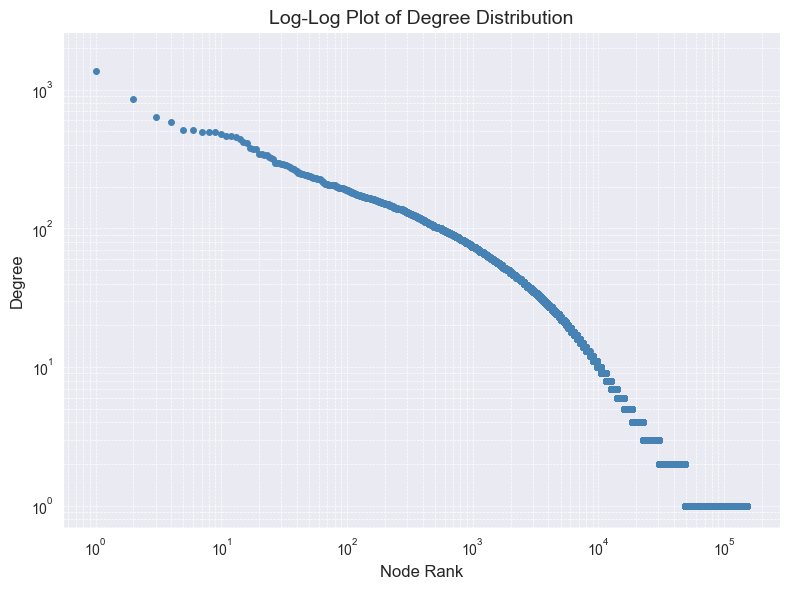

In [94]:
degrees = [d for i, d in G.degree()]
degree_counts = sorted(degrees, reverse=True)

plt.figure(figsize=(8, 6))
plt.loglog(degree_counts, marker='o', linestyle='none', markersize=4, color='steelblue')
plt.title('Log-Log Plot of Degree Distribution', fontsize=14)
plt.xlabel('Node Rank', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

### 6.2 Sampled Subgraph Colored by Community

We visualize a sample of 200 nodes from the graph, coloring each node by its Louvain community ID.  
This provides a visual sense of how well-separated communities appear in the collaboration space.


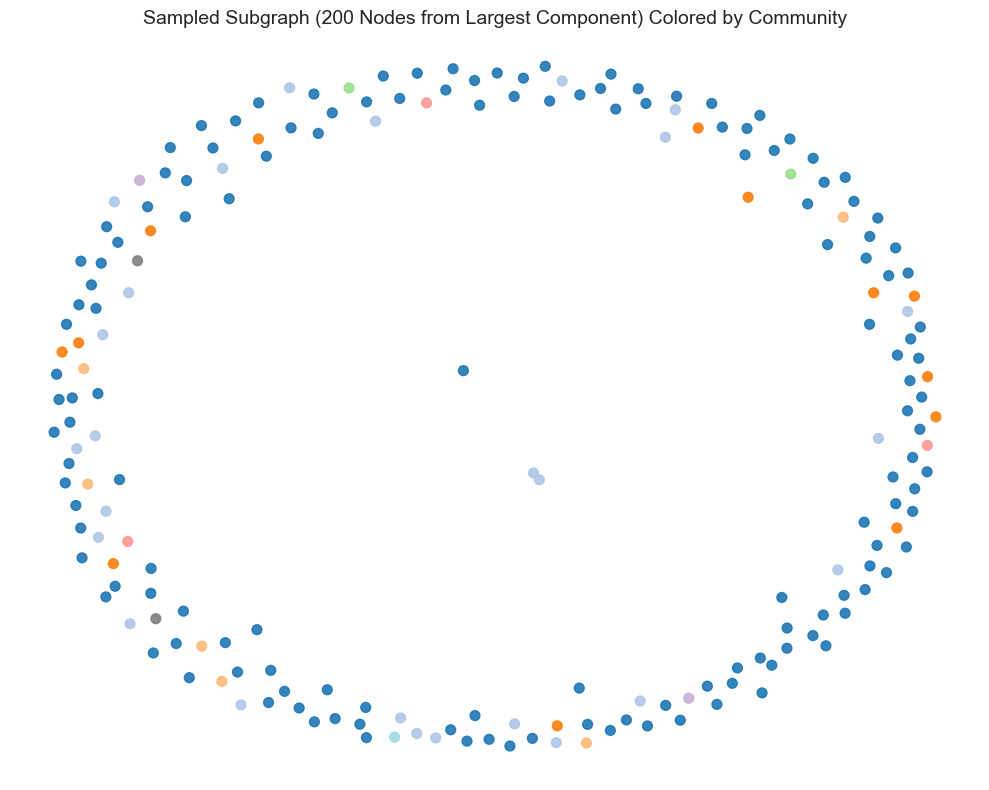

In [95]:
# Get largest connected component
largest_cc = max(nx.connected_components(G), key=len)
subsample = random.sample(list(largest_cc), 200)
subG = G.subgraph(subsample)

pos = nx.spring_layout(subG, seed=42)
colors = [G.nodes[n].get("community", 0) for n in subG.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(subG, pos, node_color=colors, cmap=plt.cm.tab20, node_size=50, alpha=0.9)
nx.draw_networkx_edges(subG, pos, alpha=0.3, width=0.5)
plt.title("Sampled Subgraph (200 Nodes from Largest Component) Colored by Community", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# THIS WILL BE DIFFERENT EVERY RUN BECAUSE IT IS SAMPLING - Probably be better to use Gephi

### 6.3 Community Size Distribution

To understand the global distribution of community sizes, we plot a histogram showing the number of artists in each community.

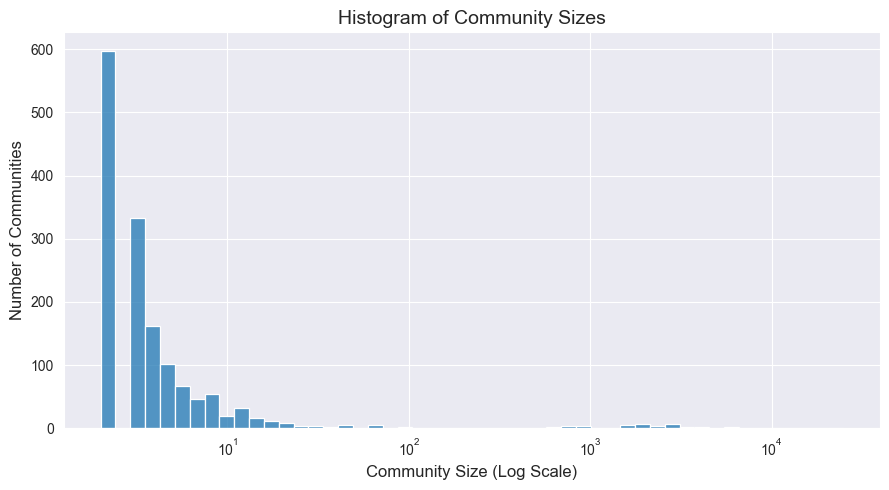

In [96]:
community_sizes = Counter(nx.get_node_attributes(G, "community").values())
sizes = list(community_sizes.values())

plt.figure(figsize=(9, 5))
sns.histplot(sizes, bins=50, kde=False, log_scale=(True, False))
plt.title("Histogram of Community Sizes", fontsize=14)
plt.xlabel("Community Size (Log Scale)", fontsize=12)
plt.ylabel("Number of Communities", fontsize=12)
plt.tight_layout()
plt.show()

### 6.4 Connected Component Sizes

While most of our analysis focuses on the largest connected component, it's helpful to visualize how the network fragments overall.  
This histogram shows the size distribution of all connected components in the graph.


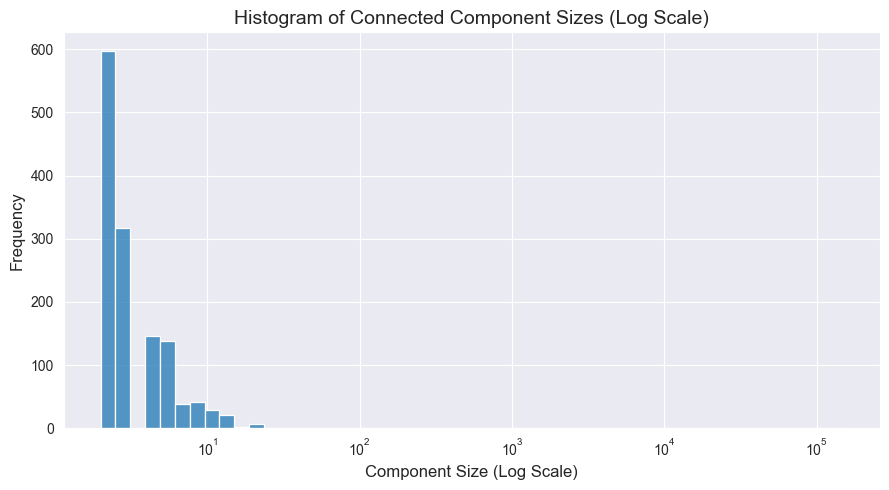

In [97]:
component_sizes = [len(c) for c in nx.connected_components(G)]

plt.figure(figsize=(9, 5))
sns.histplot(component_sizes, bins=50, log_scale=(True, False))
plt.title("Histogram of Connected Component Sizes (Log Scale)", fontsize=14)
plt.xlabel("Component Size (Log Scale)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

## 6.5 Gephi Export

We export the network for further analysis via Gephi

In [98]:
def sanitize_node_attributes(graph):
    for node, data in graph.nodes(data=True):
        for key, value in data.items():
            # Convert lists/dicts to comma-separated strings
            if isinstance(value, (list, dict)):
                graph.nodes[node][key] = str(value)

# Apply the fix before export
gephiExportFile = "spotify_collaboration_graph.gexf"
sanitize_node_attributes(G)
nx.write_gexf(G, gephiExportFile)
print("Successfully Produced: ", gephiExportFile)

Successfully Produced:  spotify_collaboration_graph.gexf


## Section 6 Summary: Network Visualizations

This section visualizes key structural properties of the Spotify artist collaboration graph:

- **Degree Distribution (6.1)**: A log-log plot confirms a heavy-tailed distribution — a small number of artists collaborate extensively while most have very few connections. This is consistent with scale-free behavior observed in real-world social and information networks.

- **Subgraph Colored by Community (6.2)**: A 200-node sample from the largest connected component reveals visually distinct Louvain communities. This supports the presence of dense collaboration clusters and genre-based subgroups within the global network.

- **Community Size Distribution (6.3)**: A histogram with a log-scaled x-axis shows that most communities are small (e.g., niche genres or local scenes), while a few are extremely large (e.g., global pop or EDM scenes). The largest detected community contains over 24,000 artists.

- **Connected Component Sizes (6.4)**: Most of the graph’s 1,500+ connected components are tiny and isolated, but one giant component spans ~153,000 artists. This contrast illustrates the difference between connectivity islands and intra-cluster modularity.

- **Gephi Export (6.5)**: To support interactive exploration, the network (with cleaned metadata) was successfully exported to the recommended GEXF format using `nx.write_gexf()`. This enables further visual analysis in Gephi, including dynamic layout tuning, modularity color-coding, and metadata-based filtering.

Together, these visualizations reveal a large, sparse, yet highly modular collaboration ecosystem driven by a few influential hubs and many localized communities. This structure forms the foundation for artist recommendation models in the next section.


## Preprocessing for Recommendation System

To ensure meaningful and diverse recommendation outputs, we first identify well-connected artists suitable for analysis.  
We filter the graph for artists with:
- A degree between 30 and 1000 (to avoid overly sparse or dominant hub nodes)
- A known Louvain community label
- A valid artist name

We then sort by degree and select a small group of artists from different communities to use as targets for our unsupervised link prediction experiments.

In [99]:
# Filter to artists with decent connectivity and known community
qualified_artists = [
    (node, data)
    for node, data in G.nodes(data=True)
    if G.degree(node) >= 30
    and G.degree(node) <= 1000
    and "community" in data
    and "name" in data
]

# Sort by degree (descending) and pick top 20
qualified_artists = sorted(qualified_artists, key=lambda x: G.degree(x[0]), reverse=True)[:20]

# Display
print("Top candidate artists for testing recommendation models:\n")
for node, data in qualified_artists:
    print(f"Artist: {data['name']} | Node: {node}")
    print(f"  Degree: {G.degree(node)} | Community: {data['community']}\n")

Top candidate artists for testing recommendation models:

Artist: Mc Gw | Node: 0f1IECbrVV952unZkzrsg2
  Degree: 858 | Community: 11

Artist: MC MN | Node: 4hV3aU0WKvFaiX5ugXP5hp
  Degree: 632 | Community: 11

Artist: Jean Sibelius | Node: 7jzR5qj8vFnSu5JHaXgFEr
  Degree: 580 | Community: 13

Artist: Armin van Buuren | Node: 0SfsnGyD8FpIN4U4WCkBZ5
  Degree: 513 | Community: 10

Artist: Gucci Mane | Node: 13y7CgLHjMVRMDqxdx0Xdo
  Degree: 509 | Community: 0

Artist: Steve Aoki | Node: 77AiFEVeAVj2ORpC85QVJs
  Degree: 498 | Community: 0

Artist: Snoop Dogg | Node: 7hJcb9fa4alzcOq3EaNPoG
  Degree: 495 | Community: 0

Artist: Diplo | Node: 5fMUXHkw8R8eOP2RNVYEZX
  Degree: 494 | Community: 0

Artist: Tiësto | Node: 2o5jDhtHVPhrJdv3cEQ99Z
  Degree: 475 | Community: 0

Artist: A.R. Rahman | Node: 1mYsTxnqsietFxj1OgoGbG
  Degree: 463 | Community: 5

Artist: Mc Delux | Node: 3l4fsEzoeabsET7ddv0lZW
  Degree: 461 | Community: 11

Artist: David Guetta | Node: 1Cs0zKBU1kc0i8ypK3B9ai
  Degree: 452 | 

In [100]:
# Pick 3 artists from the list (from different communities)
target_artist1 = "7hJcb9fa4alzcOq3EaNPoG"  # Snoop Dogg, Community 0
target_artist2 = "3dRfiJ2650SZu6GbydcHNb"  # John Williams, Community 13
target_artist3 = "0TnOYISbd1XYRBk9myaseg"  # Pitbull, Community 4

### 7.1 Generalized Recommendation Function

To reduce code redundancy and ensure consistency across similarity-based recommendation methods, we define a unified function called `recommend_artists`.

**Purpose**  
This function generates collaboration recommendations for a given artist using one of three structural similarity metrics:
- **Adamic/Adar Index**: Rewards rare shared collaborators between artists.
- **Jaccard Coefficient**: Measures the ratio of shared to total collaborators.
- **Preferential Attachment**: Assumes well-connected artists are more likely to gain new links.

**How It Works**
- The function restricts the candidate pool to non-neighbors within the same Louvain community, ensuring stylistically relevant suggestions.
- It computes the chosen similarity score for each candidate pair.
- The results are sorted and visualized as a horizontal bar chart.
- The function returns a compact DataFrame with only `target_name` and the associated score for clarity.

This design enables consistent evaluation of all three methods across multiple artists, while also simplifying code maintenance and visualization formatting.


In [101]:
def recommend_artists(target_artist, G, method="adamic", top_n=10):

    # Retrieve metadata
    target_name = G.nodes[target_artist].get("name", "Unknown")
    target_comm = G.nodes[target_artist].get("community", None)
    neighbors = set(G.neighbors(target_artist))

    # Candidate pool: same community, not already collaborators
    candidates = [
        (target_artist, node)
        for node in G.nodes
        if node != target_artist
        and node not in neighbors
        and G.nodes[node].get("community", None) == target_comm
    ]

    print(f"Target Artist: {target_name}")
    print(f"Community ID: {target_comm}")
    print(f"Candidate pool: {len(candidates)}")
    print(f"Candidate Pool = Number of artists in community {target_comm} that {target_name} has not collobrated with")

    # Compute similarity scores - used different colors to distinguish charts
    if method == "adamic":
        scores = list(nx.adamic_adar_index(G, candidates))
        score_col = "adamic_adar"
        color = "steelblue"
        title = "Adamic/Adar"
    elif method == "jaccard":
        scores = list(nx.jaccard_coefficient(G, candidates))
        score_col = "jaccard"
        color = "seagreen"
        title = "Jaccard"
    elif method == "pa":
        scores = list(nx.preferential_attachment(G, candidates))
        score_col = "preferential_attachment"
        color = "tomato"
        title = "Preferential Attachment"
    else:
        raise ValueError("Invalid method. Choose from: 'adamic', 'jaccard', 'pa'")

    # Convert and filter
    df = pd.DataFrame(scores, columns=["source", "target", score_col])
    df = df[df[score_col] > 0].sort_values(by=score_col, ascending=False).head(top_n)
    df["target_name"] = df["target"].map(lambda x: G.nodes[x].get("name", x))

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=score_col, y="target_name", data=df, color=color)
    plt.title(f"Top {title} Recommendations for {target_name}", fontsize=14)
    plt.xlabel(f"{title} Score")
    plt.ylabel("Recommended Artist")
    plt.tight_layout()
    plt.show()

    # Return only target_name and score
    return df[["target_name", score_col]]

### 7.2 Artist Recommendations using Adamic/Adar Similarity

We apply the Adamic/Adar index to suggest potential future collaborators for a given artist. To improve the relevance of suggestions and reduce sparsity, we restrict candidate artists to those in the same Louvain community but who have not already collaborated with the target artist. The Adamic/Adar index gives higher scores to pairs who share rare collaborators, prioritizing meaningful structural proximity over sheer popularity.



Target Artist: Snoop Dogg
Community ID: 0
Candidate pool: 24335
Candidate Pool = Number of artists in community 0 that Snoop Dogg has not collobrated with


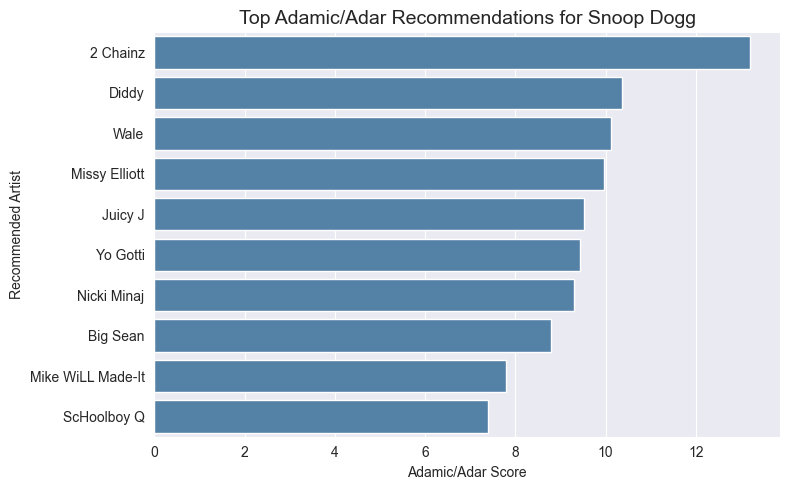

,target_name,adamic_adar
361,2 Chainz,13.205180
102,Diddy,10.367553
212,Wale,10.112258
576,Missy Elliott,9.970893
63,Juicy J,9.515644
718,Yo Gotti,9.434766
83,Nicki Minaj,9.309826
677,Big Sean,8.791844
721,Mike WiLL Made-It,7.793813
663,ScHoolboy Q,7.390744


In [102]:
recommend_artists(target_artist1, G, method="adamic")

### 7.3 Artist Recommendations using Jaccard Similarity

We now apply the Jaccard Coefficient to suggest new collaborators for a target artist. This metric compares the overlap between two artists' collaborators as a ratio of their total combined collaborators. We again restrict candidate artists to those within the same community as the target, and who have not yet collaborated with them. This ensures recommendations are focused and musically contextual.


Target Artist: Snoop Dogg
Community ID: 0
Candidate pool: 24335
Candidate Pool = Number of artists in community 0 that Snoop Dogg has not collobrated with


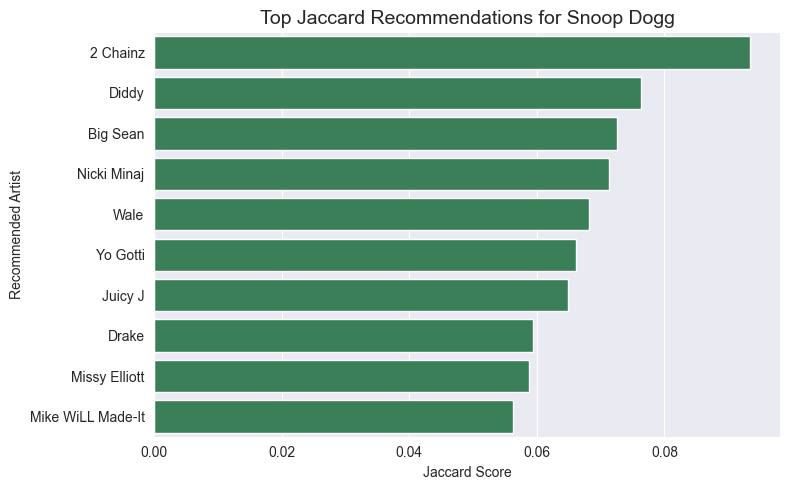

,target_name,jaccard
361,2 Chainz,0.093458
102,Diddy,0.076271
677,Big Sean,0.072539
83,Nicki Minaj,0.071313
212,Wale,0.068182
718,Yo Gotti,0.066129
63,Juicy J,0.064915
1633,Drake,0.059441
576,Missy Elliott,0.058719
721,Mike WiLL Made-It,0.056239


In [103]:
recommend_artists(target_artist1, G, method="jaccard")

### 7.4 Artist Recommendations using Preferential Attachment

We now apply the Preferential Attachment score to recommend potential collaborators. This metric assumes that artists who are already well-connected are more likely to attract additional links.This score is unbounded and heavily influenced by node degree, often promoting highly popular artists.  As with previous methods, we restrict candidates to the same community and exclude existing collaborators.


Target Artist: Snoop Dogg
Community ID: 0
Candidate pool: 24335
Candidate Pool = Number of artists in community 0 that Snoop Dogg has not collobrated with


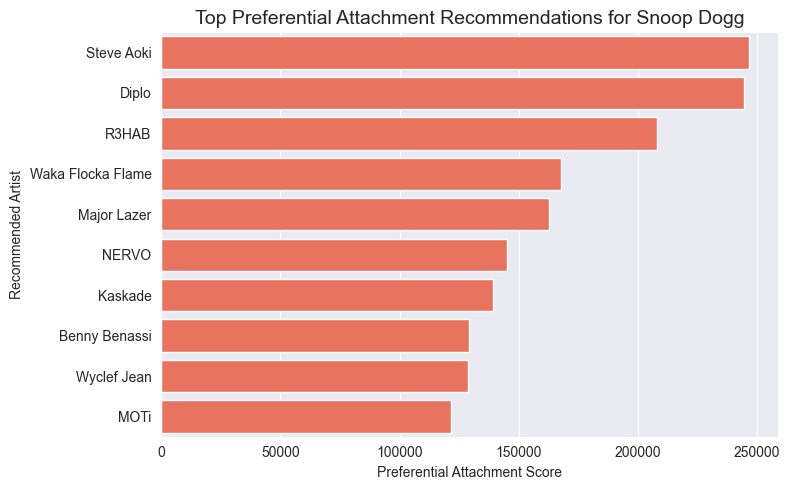

,target_name,preferential_attachment
139,Steve Aoki,246510
614,Diplo,244530
230,R3HAB,207900
470,Waka Flocka Flame,167805
141,Major Lazer,162855
447,NERVO,145035
258,Kaskade,139095
105,Benny Benassi,129195
176,Wyclef Jean,128700
49,MOTi,121770


In [104]:
recommend_artists(target_artist1, G, method="pa")

## Section 7 Summary: Artist Recommendation Modeling

This section applied graph-based link prediction techniques to recommend potential future collaborations between artists focusing solely on network structure rather than user behavior.

### Key Setup:
- Target artists were selected from different Louvain communities (e.g., Snoop Dogg).
- Candidates were limited to non-neighbors in the same community, simulating in-genre recommendations among unlinked artists.

### Methods Applied:
- **Adamic/Adar Index**: Prioritizes rare shared collaborators.
- **Jaccard Coefficient**: Measures overlap in collaborator sets relative to union size.
- **Preferential Attachment**: Scores based on the product of degrees; favors already popular artists.

### Key Observations:
- **Adamic/Adar** and **Jaccard** yielded genre-consistent recommendations grounded in local structure.
- **Preferential Attachment** surfaced high-degree global hubs (e.g., Diplo), often favoring popularity over stylistic match.
- Each method reflects a different structural bias, offering complementary insights.

This modeling framework demonstrates how network structure alone can support meaningful artist discovery and collaboration planning, even without user listening data or genre metadata.


## 8. Method Comparison Across Artists

**Purpose**  
- Assess how different structural recommendation strategies perform when applied to artists from diverse musical backgrounds.  
- Evaluate whether each method yields contextually appropriate recommendations for artists with varying collaboration patterns and genres.

**This includes:**  
- **8.1 Snoop Dogg (Rap)**: Apply Adamic/Adar, Jaccard, and Preferential Attachment methods.  
- **8.2 John Williams (Film Score)**: Apply the same three methods to an orchestral composer.  
- **8.3 Pitbull (Pop/Latin)**: Evaluate all three methods for a high-profile, cross-genre collaborator.

In [105]:
def compare_methods_for_artist(artist_id):
    target_name = G.nodes[artist_id].get("name", "Unknown")
    target_comm = G.nodes[artist_id].get("community", None)
    neighbors = set(G.neighbors(artist_id))

    # Candidate pool: same community, not already collaborators
    candidates = [
        (artist_id, node)
        for node in G.nodes
        if node != artist_id
        and node not in neighbors
        and G.nodes[node].get("community", None) == target_comm
    ]

    # Compute scores
    jaccard = list(jaccard_coefficient(G, candidates))
    adamic = list(adamic_adar_index(G, candidates))
    pa = list(preferential_attachment(G, candidates))

    # Convert to DataFrames
    def to_df(scores, metric):
        df = pd.DataFrame(scores, columns=["source", "target", metric])
        df = df[df[metric] > 0].sort_values(by=metric, ascending=False).head(10)
        df["target_name"] = df["target"].map(lambda x: G.nodes[x].get("name", x))
        return df

    jaccard_df = to_df(jaccard, "jaccard")
    adamic_df = to_df(adamic, "adamic_adar")
    pa_df = to_df(pa, "pa_score")

    # Plot
    plt.figure(figsize=(15, 5))
    titles = ["Jaccard", "Adamic/Adar", "Preferential Attachment"]
    dfs = [jaccard_df, adamic_df, pa_df]
    metrics = ["jaccard", "adamic_adar", "pa_score"]
    colors = ["seagreen", "steelblue", "tomato"]

    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        sns.barplot(x=metrics[i], y="target_name", data=dfs[i], color=colors[i])
        ax.set_title(f"{titles[i]} for {target_name}")
        ax.set_xlabel("Score")
        ax.set_ylabel("Recommended Artist")

    plt.tight_layout()
    plt.show()

### 8.1 Recommendations for Snoop Dogg

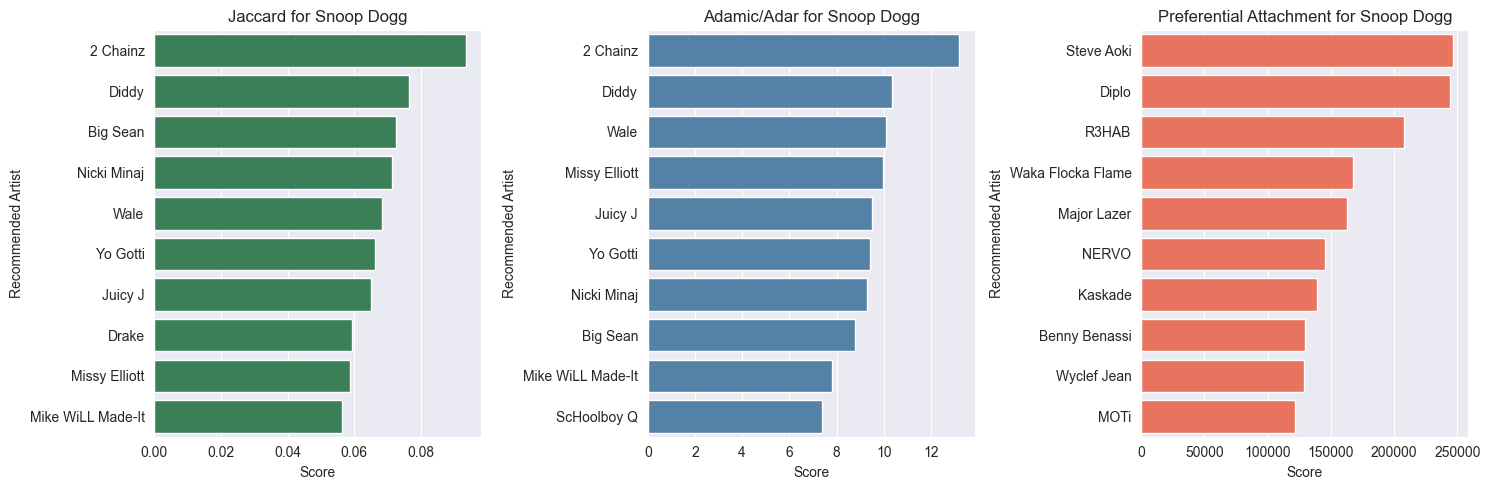

In [106]:
compare_methods_for_artist(target_artist1)

### 8.2 Recommendations for John Williams

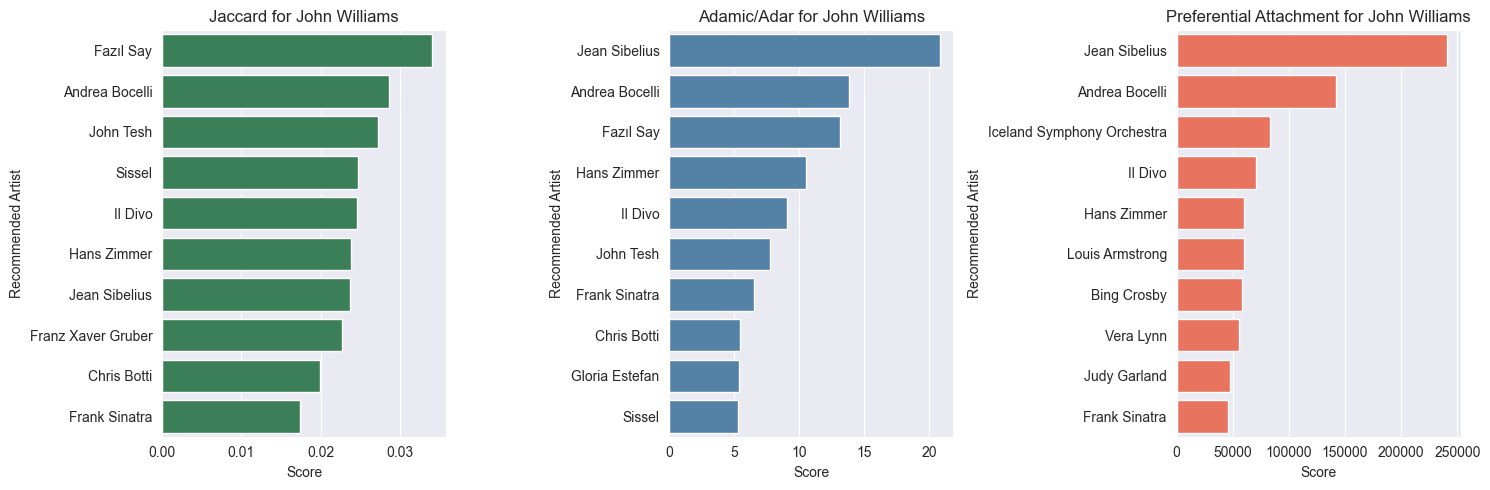

In [107]:
compare_methods_for_artist(target_artist2)

### 8.3 Recommendations for Pitbull

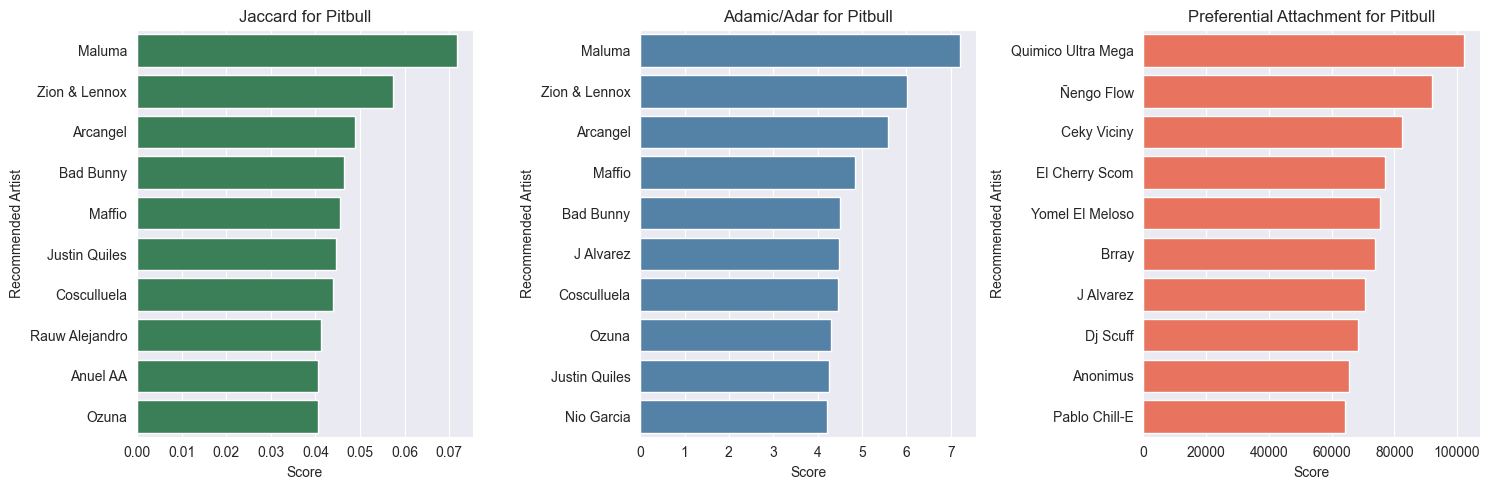

In [108]:
compare_methods_for_artist(target_artist3)

## Section 8 Summary: Method Comparison per Artist

This section applied three unsupervised link prediction methods (Adamic/Adar, Jaccard, and Preferential Attachment) to three artists from different Louvain communities:

- **Snoop Dogg** (Rap, Community 0)  
- **John Williams** (Film Score, Community 13)  
- **Pitbull** (Pop/Latin, Community 4)

### Key Observations:

- **Jaccard Coefficient**  
  - Prioritized artists with overlapping collaborator sets (e.g., 2 Chainz for Snoop Dogg, Hans Zimmer for John Williams).  
  - Recommendations tended to stay within stylistic and genre boundaries due to reliance on shared neighbors.

- **Adamic/Adar Index**  
  - Often reinforced Jaccard results but gave more weight to rare, shared collaborators.  
  - Produced slightly more nuanced scores, especially for less mainstream artists.

- **Preferential Attachment**  
  - Tended to surface high-degree “hub” artists, regardless of genre (e.g., Diplo, Steve Aoki, Andrea Bocelli).  
  - Results were driven more by global popularity than contextual fit.

### Insight:

Jaccard and Adamic/Adar produced genre-aligned, structurally coherent recommendations, making them useful for maintaining musical context.  
Preferential Attachment highlighted network-dominant figures, emphasizing exposure potential over similarity.

These differences underscore the need to match the method to the recommendation goal, whether fostering niche growth, mainstream reach, or bridging communities.



# Final Summary and Reflections

**Purpose**  
- Synthesize findings from all stages of the project in relation to the stated research goals.  
- Frame the completed work in terms of its analytical contributions and alignment with course deliverables.


### Summary of Contributions

This project investigated structural patterns and recommendation strategies within the Spotify Artist Feature Collaboration Network, a large-scale graph of over 150,000 artists and 300,000 collaboration edges. The primary goals were to identify influential artists, detect genre-based communities, explore the relationship between influence and popularity, and improve artist recommendations using graph-based methods.

We began by analyzing the artist metadata and collaboration structure using descriptive statistics and network centrality measures. Degree, eigenvector, and sampled betweenness centrality helped reveal high-influence artists and structural hubs, while the clustering coefficient highlighted moderately cohesive local structures.

Community detection via the Louvain algorithm uncovered over 1,500 modular clusters, many of which reflected genre or industry patterns. A range of network visualizations supported interpretation, including degree distributions, subgraph layouts, and community size histograms.

In the second half of the project, we implemented unsupervised artist recommendation models using:
- Adamic/Adar Index
- Jaccard Coefficient
- Preferential Attachment

These were applied consistently across selected artists from different communities to evaluate the strengths and biases of each method. Results showed that Adamic/Adar and Jaccard tended to generate stylistically coherent suggestions, while Preferential Attachment favored high-degree global hubs, often outside genre context.

We also evaluated the relationship between centrality and popularity using Pearson correlation, showing moderate alignment (correlation ≈ 0.34), thus addressing the missing link between structural influence and external success metrics.


### Alignment with Project Proposal

This work directly addressed all components of the initial project plan:

- **Identify influential artists** -> Centrality metrics and global rankings  
- **Detect and analyze communities** ->  Louvain clustering and artist sampling  
- **Relate structure to popularity** ->  Correlation analysis  
- **Improve recommendations** -> Link prediction models across artists and genres


## References

**Course Materials**
- CS 5564 Lecture Slides and Handouts:
  - *networks-part1.pdf*, *Networks-part2.pdf*, *MoreonNetworks.pdf*: Provided theoretical foundations on graph structures, centrality metrics, and collaboration models.
  - *CommunityDetection.pdf*: Explained modularity maximization using the Louvain algorithm.
  - *LinkAnalysis.pdf*: Introduced structural recommendation techniques including Adamic/Adar, Jaccard, and Preferential Attachment.
  - *RecommendationsIntro.pdf*: Focused on link prediction methods and graph-based recommender systems.
  - *RichUserInteractions.pdf*: Discussed practical use cases of collaborative filtering and network-based user/item relationships.
  - *gephi-tutorial-quick_start.pdf*: Used to guide external visualization in Gephi.
  - *02_networkx.ipynb*: Served as a foundational code base for node/edge creation and early-stage plotting with NetworkX.


- Coursework:
  - *HW1–HW2 Notebooks*: Provided reusable patterns for data inspection, plotting, and graph computation workflows.
  

**Dataset**
- Freyberg, J. (2022). *Spotify Artist Feature Collaboration Network*. Kaggle.  
  https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network  
 

**Documentation and Libraries**
- NetworkX Documentation  
  https://networkx.org/documentation/stable/  
  Used for all network construction, centrality scoring, and recommendation logic.

- pandas Documentation  
  https://pandas.pydata.org/docs/  
  Core library for data wrangling, grouping, filtering, and correlation analysis.

- seaborn and matplotlib Documentation  
  https://seaborn.pydata.org/  
  https://matplotlib.org/stable/  
  Used for generating bar plots, histograms, degree distributions, and heatmaps.

- python-louvain Documentation  
  https://python-louvain.readthedocs.io/  
  External package used to assign community IDs using Louvain modularity clustering.





## 7. Artist Recommendation Modeling

**Purpose**  
- Explore graph-based methods to recommend potential artist collaborations or similar artists.  
- Use unsupervised link prediction techniques based solely on structural proximity in the collaboration graph.  
- Simulate the recommendation process by scoring non-connected artist pairs from the same community.

**This includes:**  
- **Preprocessing for Recommendation System**: Filter artists to ensure fair comparisons across target nodes, based on degree, metadata presence, and community membership.
- **7.1 Generalized Recommendation Function**: Function to implement the following three methods
- **7.2 Artist Recommendations using Adamic/Adar Similarity**: Prioritize artists with shared rare collaborators, using a structural similarity score.  
- **7.3 Artist Recommendations using Jaccard Similarity**: Recommend artists with overlapping collaborator sets.  
- **7.4 Artist Recommendations using Preferential Attachment**: Rank candidates based on total connectivity and exposure potential.